# Markov Models Runthrough
#### by Alvin Zhang
#### Notes and examples based on Bishop's "Pattern Recognition and Machine Learning"

### Definitions
A Markov model is a stochastic model useful for sequential data, since the model assumes that future states only depend on the current/most recent states. A Markov chain is a Markov model that models the state through time. By adding latent variables to a Markov model, we obtain state space models. A hidden Markov model is a state space model with discrete latent variables, while a linear dynamical system is a state space model with Gaussian latent variables.

### Formulations
#### Markov Chains
In a first order Markov chain, each state (except for the first one) is dependent only on the previous one. This is graphically represented as shown below:
<img src="1ordermc.png">
This is formulated as
\begin{align*}
    p\left(\vec{x}_1,...,\vec{x}_N\right) &= p\left(\vec{x}_1\right)p\left(\vec{x}_2|\vec{x}_1\right)p\left(\vec{x}_3|\vec{x}_2\right)...p\left(\vec{x}_N|\vec{x}_{N-1}\right)\\
    &= p\left(\vec{x}_1\right)\prod_{n=2}^Np\left(\vec{x}_n|\vec{x}_{n-1}\right).
\end{align*}
Note that $p\left(\vec{x}_n|\vec{x}_1,...,\vec{x}_{n-1}\right) = p\left(\vec{x}_n|\vec{x}_{n-1}\right)$.

A second order Markov chain depends on the previous two states, and is graphically represented as
<img src="2ordermc.png">
This is similarly formulated as
\begin{align*}
    p\left(\vec{x}_1,...,\vec{x}_N\right) = p\left(\vec{x}_1\right)p\left(\vec{x}_2|\vec{x}_1\right)\prod_{n=3}^Np\left(\vec{x}_n|\vec{x}_{n-1},\vec{x}_{n-2}\right).
\end{align*}

#### Hidden Markov Models
A hidden Markov model contains discrete latent variables, and is graphically represented as
<img src="hiddenmm.png">
This is formulated as
\begin{align*}
     p\left(\vec{x}_1,...,\vec{x}_N,\vec{z}_1,...,\vec{z}_N\right) &= p\left(\vec{z}_1\right)p\left(\vec{x}_1|\vec{z}_1\right)p\left(\vec{z}_2|\vec{z}_1\right)p\left(\vec{x}_2|\vec{z}_2\right)...p\left(\vec{x}_N|\vec{z}_{N-1}\right)p\left(\vec{x}_N|\vec{z}_N\right)\\
     &= \left(p\left(\vec{z}_1\right)\prod_{n=2}^Np\left(\vec{z}_n|\vec{z}_{n-1}\right)\right)\prod_{n=1}^Np\left(\vec{x}_n|\vec{z}_n\right)
\end{align*}

Note we have that each latent variable $\vec{z}_n$ depends on the previous latent variable by $p\left(\vec{z}_n|\vec{z}_{n-1}\right)$. The latent variables $\vec{z}_n$ are binary and of length $K$. For discrete latent variables with $K$ states, we have the transition probabilities of transitioning from state to state in a $K\times K$ matrix called $\mathbf{A}$ where $A_{jk}$ denotes the probability of transitioning from state $j$ to state $k$. Hence, we can write
$$p\left(\vec{z}_n\big|\vec{z}_{n-1}, \mathbf{A}\right)=\prod_{k=1}^K\prod_{j=1}^KA_{jk}^{z_{n-1,j}z_{nk}}$$
where $z_{nk}=1$ is $z_n$ is at state $k$ and $0$ otherwise. For the first latent variable $\vec{z}_1$, we have priors $\vec{\pi}$ represented by $K$ probabilities $\pi_k$, so
$$p\left(\vec{z}_1|\vec{\pi}\right)=\prod_{k=1}^K\pi_k^{z_{1k}}.$$
For the "emission probabilities" $p\left(\vec{x}_n|\vec{z}_n\right)$, we also specify a set of $K$ parameters $\vec{\phi}$ that govern this distribution. $\phi_k$ corresponds to the $k^{\text{th}}$ state of $\vec{z}_n$, so we can rewrite the conditionals as
$$p\left(\vec{x}_n\big|\vec{z}_n,\vec{\phi}\right)=\prod_{k=1}^Kp\left(\vec{x}_n|\phi_k\right)^{z_{nk}}.$$
Rewriting everything with these new parameters, and letting $\mathbf{X}=\{\vec{x}_1, ...,\vec{x}_N\}, \mathbf{Z}=\{\vec{z}_1,...\vec{z}_N\}$, we have
$$p\left(\mathbf{X},\mathbf{Z}\big|\vec{\pi}, \mathbf{A}, \vec{\phi}\right)=\left(p\left(\vec{z}_1\big|\vec{\pi}\right)\prod_{n=2}^Np\left(\vec{z}_n\big|\vec{z}_{n-1}, \mathbf{A}\right)\right)\left(\prod_{m=1}^Np\left(\vec{x}_m\big|\vec{z}_m,\vec{\phi}\right)\right).$$

As an example, we demonstrate a hidden Markov model below with Gaussian emissions:

In [1]:
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(30)

A = np.array([[0.90, 0.05, 0.05],
              [0.05, 0.90, 0.05],
              [0.05, 0.05, 0.90]])
means = np.array([[0.25, 0.25], 
                  [0.75, 0.50],
                  [0.25, 0.75]])
covs = np.array([[[.01, 0], [0, .02]],
                 [[.02, .01], [.01, .01]],
                 [[.02, -.01], [-.01, .01]]])
priors = np.array([[0.5], [0.25], [0.25]])

max_pts = 100
points = np.zeros([max_pts, 2])
states = np.zeros(max_pts+1, dtype=np.int)
states[0] = np.random.choice([0, 1, 2], p=priors.ravel())
for i in range(max_pts):
    points[i] = np.random.multivariate_normal(means[states[i]], covs[states[i]])
    states[i+1] = (np.random.choice([0, 1, 2], p=A[states[i]]))

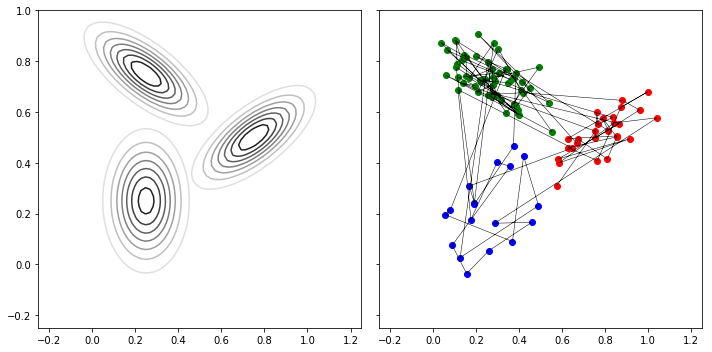

In [2]:
from scipy.stats import multivariate_normal

def plot_gaussian_contours(means, covs, ax, xmin, xmax, ymin, ymax):
    for state in range(covs.shape[0]):
        x = np.linspace(xmin, xmax, 100)
        y = np.linspace(ymin, ymax, 100)
        x, y = np.meshgrid(x, y)
        z = np.zeros(x.shape)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                z[i, j] = multivariate_normal.pdf([x[i, j], y[i, j]], mean=means[state], cov=covs[state])
        ax.contour(x, y, z, cmap='binary')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
plot_gaussian_contours(means, covs, ax1, -0.5, 1.5, -0.5, 1.5)
for i, marker in [(0, 'bo'), (1, 'ro'), (2, 'go')]:
    ax2.plot(points[states[:-1]==i, 0], points[states[:-1]==i, 1], marker)
ax2.plot(points[:, 0], points[:, 1], 'k-', lw=0.5)

ax2.set_xlim([-0.25, 1.25])
ax2.set_ylim([-0.25, 1])
plt.tight_layout()
plt.show()

There are also certain structures that restrict certain transitions. For example, here are two different lattice diagrams shown below:
<img src="structs.png">
### HMM Training (Maximum Likelihood)
Given an observed data set $\mathbf{X}=\{\vec{x}_1,...,\vec{x}_N\}$ and denoting the parameters $\{\vec{\pi}, \mathbf{A}, \vec{\phi}\}$ as $\vec{\theta}$, the likelihood function is given by marginalizing out $\mathbf{Z}$ in the above joint distribution:
$$p\left(\mathbf{X}\big|\vec{\theta}\right)=\sum_{\mathbf{Z}}p\left(\mathbf{X},\mathbf{Z}\big|\vec{\theta}\right)$$
This is difficult to evaluate, so we must use the expectation maximization algorithm.
#### E step:
Let the initial model parameters be $\vec{\theta}^{\text{old}}$. We need to evaluate the posterior of the latent variables
$$p\left(\mathbf{Z}\big|\mathbf{X},\vec{\theta}^{\text{old}}\right),$$
which we use to calculate the expectation of the log joint likelihood, which is what we want to maximize:
$$Q\left(\vec{\theta},\vec{\theta}^{\text{old}}\right)=\sum_{\mathbf{Z}}p\left(\mathbf{Z}\big|\mathbf{X},\vec{\theta}^{\text{old}}\right)\log p\left(\mathbf{X},\mathbf{Z}\big|\vec{\theta}\right).$$
For notational purposes, we denote 
\begin{align*}
\gamma\left(\vec{z}_n\right)&=p\left(\vec{z}_n\big|\mathbf{X},\vec{\theta}^{\text{old}}\right) & \text{(marginal posterior of } \vec{z}_n)\\
\xi\left(\vec{z}_{n-1}, \vec{z}_n\right) &= p\left(\vec{z}_{n-1},\vec{z}_n\big|\mathbf{X},\vec{\theta}^{\text{old}}\right) & \text{(joint posterior of } \vec{z}_{n-1}, \vec{z}_n )
\end{align*}
with components
\begin{align*}
   \gamma(z_{nk}) &= \mathbb{E}[z_{nk}]=\sum_{\vec{z}}\gamma(\vec{z})z_{nk}\\
   \xi(z_{n-1,j},z_{nk}) &= \mathbb{E}[z_{n-1,j}, z_{nk}] = \sum_{\vec{z}}\gamma(\vec{z})z_{n-1,j}z_{nk}.
\end{align*}
Substituting this into $$p\left(\mathbf{X},\mathbf{Z}\big|\vec{\theta}\right)=\left(p\left(\vec{z}_1\big|\vec{\pi}\right)\prod_{n=2}^Np\left(\vec{z}_n\big|\vec{z}_{n-1}, \mathbf{A}\right)\right)\left(\prod_{m=1}^Np\left(\vec{x}_m\big|\vec{z}_m,\vec{\phi}\right)\right)$$
and the expression for $Q$, we get
\begin{align*}
    Q\left(\vec{\theta}, \vec{\theta}^{\text{old}}\right) &= \sum_{k=1}^K\gamma(z_{1k})\log\pi_k + \sum_{n=2}^N\sum_{j=1}^K\sum_{k=1}^K\xi\left(z_{n-1, j}, z_{nk}\right)\log A_{jk} \\
    &\qquad + \sum_{n=1}^N\sum_{k=1}^K\gamma(z_{nk})\ln p\left(\vec{x}_n\big|\vec{\phi}_k \right).
\end{align*}
##### Forward-backward algorithm
To find the quantities $\gamma\left(z_{nk}\right)$ and $\xi\left(z_{n-1,j},z_{nk}\right)$, we use the forward-backward algorithm/Baum-Welch algorithm, specifically the alpha-beta algorithm. 

Note that to find $\gamma(z_{nk})$, we need $\gamma\left(\vec{z}_n\right)$, which by Bayes' theorem states
\begin{align*}
    \gamma\left(\vec{z}_n\right) &= p\left(\vec{z}_n\big|\mathbf{X}\right)\\
    &= \frac{p\left(\mathbf{X}\big|\vec{z}_n\right)p\left(\vec{z}_n\right)}{p\left(\mathbf{X}\right)}\\
    &= \frac{p\left(\vec{x}_1,...,\vec{x}_n\big|\vec{z}_n\right)p\left(\vec{x}_{n+1},...,\vec{x}_N\big|\vec{z}_n\right)p\left(\vec{z}_n\right)}{p\left(\mathbf{X}\right)}\\
    &= \frac{\overbrace{p\left(\vec{x}_1,...,\vec{x}_n,\vec{z}_n\right)}^{\alpha\left(\vec{z}_n\right)}\overbrace{p\left(\vec{x}_{n+1},...,\vec{x}_N\big|\vec{z}_n\right)}^{\beta\left(\vec{z}_n\right)}}{p\left(\mathbf{X}\right)}\\
\end{align*}
where we have used an conditional independence property showed by Jordan, 2007. Using other conditional independence properties of hidden Markov models as shown in Jordan, 2007, we can also use sum and product rules to show that
$$\alpha\left(\vec{z}_n\right) = p\left(\vec{x}_n\big|\vec{z}_n\right)\sum_{\vec{z}_{n-1}}\alpha\left(\vec{z}_{n-1}\right)p\left(\vec{z}_n\big|\vec{z}_{n-1}\right).$$
(See Bishop pg. 620 for full derivation.)
The initial value of these alphas is given by
\begin{align*}
    \alpha\left(\vec{z}_1\right) &= p\left(\vec{x}_1,\vec{z}_1\right)\\
    &= p\left(\vec{x}_1\big|\vec{z}_1\right)\\
    &= \prod_{k=1}^K\left(\pi_kp\left(\vec{x}_1\big|\phi_k\right)\right)^{z_{1k}}
\end{align*}
Similarly for $\beta\left(\vec{z}_n\right)$, we can use conditional independence and sum and product rules to get
$$\beta\left(\vec{z}_n\right)=\sum_{\vec{z}_{n+1}}\beta\left(\vec{z}_{n+1}\right)p\left(\vec{x}_{n+1}\big|\vec{z}_{n+1}\right)p\left(\vec{z}_{n+1}\big|\vec{z}_n\right)$$
with an initial condition of $\beta\left(\vec{z}_N\right)=1$. (See Bishop pg. 622 for full derivation.)
We can also show that $p\left(\mathbf{X}\right)=\sum_{\vec{z}_N}\alpha\left(\vec{z}_N\right)$. Hence, we now know $\gamma\left(\vec{z}_n\right)$ since we know $\alpha\left(\vec{z}_n\right), \beta\left(\vec{z}_n\right)$, and $p(\mathbf{X})$.

Finally, we can use the definition of $\xi\left(\vec{z}_{n-1}, \vec{z}_n\right)$ to show that
$$\xi\left(\vec{z}_{n-1}, \vec{z}_n\right) = \frac{\alpha\left(\vec{z}_{n-1}\right)p\left(\vec{x}_n\big|\vec{z}_n\right)p\left(\vec{z}_n\big|\vec{z}_{n-1}\right)\beta\left(\vec{z}_n\right)}{p\left(\mathbf{X}\right)}.$$
#### M step:
We maximize $Q\left(\vec{\theta},\vec{\theta}^{\text{old}}\right)$ treating $\gamma(\vec{z}_n)$ and $\xi\left(\vec{z}_{n-1},\vec{z}_n\right)$ are constants. Using Lagrange multipliers results in
\begin{align*}
    \pi_k &= \frac{\gamma(z_{1k})}{\sum_{j=1}^K\gamma(z_{1j})}\\
    A_{jk} &= \frac{\sum_{n=2}^N\xi\left(z_{n-1,j},z_{nk}\right)}{\sum_{l=1}^K\sum_{n=2}^N\xi\left(z_{n-1,j}, z_{nl}\right)}
\end{align*}
For Gaussian emissions, $p\left(\vec{x}\big|\vec{\phi}_k\right)=\mathcal{N}\left(\vec{x}\big|\vec{\mu}_k,\mathbf{\Sigma}_k\right)$, we get
\begin{align*}
    \vec{\mu}_k &= \frac{\sum_{n=1}^N\gamma\left(z_{nk}\right)\vec{x}_n}{\sum_{n=1}^N\gamma\left(z_{nk}\right)}\\
    \mathbf{\Sigma}_k &= \frac{\sum_{n=1}^N\gamma\left(z_{nk}\right)(\vec{x}_n-\vec{\mu}_k)(\vec{x}_n-\vec{\mu}_k)^\text{T}}{\sum_{n=1}^N\gamma\left(z_{nk}\right)}
\end{align*}

The E and M steps are repeated until convergence.

A Python implementation of a hidden Markov Model with Guassian emissions follows:

In [3]:
import numpy as np
from scipy.stats import multivariate_normal as gaussian
from sklearn.cluster import KMeans

class HMMGaussian:
    def __init__(self, K):
        self.K = K
        self.A = test = np.random.rand(K, K)
        self.A /= np.sum(self.A, axis=1).reshape(-1, 1)
        
        self.pis = np.random.rand(K, 1)
        self.pis /= sum(self.pis)

        self.N = None # Number of training points
        self.D = None # Dimension of training points
        self.means = None
        self.covs = None
        self.alphas = None
        self.betas = None
        self.xis = None
        self.pX = None
    
    def fit(self, X):
        self.N, self.D = X.shape
        
        # use k means to initialize self.means, self.covs
        kmeans = KMeans(n_clusters=self.K).fit(X)
        self.means = kmeans.cluster_centers_
        self.covs = np.zeros([self.K, self.D, self.D])
        for k in range(self.K):
            self.covs[k] = np.cov(X[kmeans.labels_==k].T)

        # EM
        max_iters = 15
        for _ in range(max_iters):
            self.alphas = np.zeros([self.N, self.K])
            self.betas = np.zeros([self.N, self.K])
            self.forward(X)
            self.backward(X)
            self.pX = np.sum(self.alphas[-1])
            self.xis = np.zeros([self.N-1, self.K, self.K])
            for n in range(self.N-1):
                self.xis[n] = (self.alphas[n].reshape(-1, 1) @ self.betas[n+1].reshape(-1, 1).T) * self.A
                pxz = [gaussian.pdf(X[n+1], mean=self.means[i], cov=self.covs[i]) for i in range(self.K)]
                self.xis[n] *= pxz/self.pX
        
            self.pis = self.alphas[0]/sum(self.alphas[0])
            self.A = np.sum(self.xis, axis=0)
            self.A /= np.sum(self.A, axis=1).reshape(-1, 1)

            self.ml_mean_and_cov(X)
            print('Likelihood', self.pX)
            
    def forward(self, X):
        self.alphas[0] = [self.pis[i] * gaussian.pdf(X[0], mean=self.means[i], cov=self.covs[i])
                          for i in range(self.K)]
        for n in range(1, self.N):
            self.alphas[n] = [gaussian.pdf(X[n], mean=self.means[i], cov=self.covs[i]) *
                              sum(self.alphas[n-1][j] * self.A[j, i] for j in range(self.K))
                              for i in range(self.K)]

    def backward(self, X):
        self.betas[-1] = 1
        for n in range(self.N-2, -1, -1):
            self.betas[n] = [sum(self.betas[n+1][j] * gaussian.pdf(X[n+1], mean=self.means[j], cov=self.covs[j]) * self.A[i, j] for j in range(self.K))
                             for i in range(self.K)]
    
    def ml_mean_and_cov(self, X):
        for k in range(self.K):
            factor = sum(self.alphas[n][k] * self.betas[n][k] for n in range(self.N))
            self.means[k] = sum(self.alphas[n][k] * self.betas[n][k] * X[n] for n in range(self.N))/factor

            cov = 0
            for n in range(self.N):
                c = (points[n] - self.means[k]).reshape(-1, 1) @ (points[n] - self.means[k]).reshape(-1, 1).T
                cov += self.alphas[n][k] * self.betas[n][k] * c
            self.covs[k] = cov/factor
    

Let's try to fit the points we generated above in the 3 state hidden Markov model below with Gaussian emissions. Recall that this was done with

\begin{align*}
\mathbf{A} &= \begin{bmatrix}0.90 & 0.05 & 0.05 \\ 0.05 & 0.90 & 0.05 \\ 0.05 & 0.05 & 0.90\end{bmatrix}\\
\vec{\mu} &= [(0.25, 0.25), (0.75, 0.50), (0.25, 0.75)]\\
\vec{\Sigma} &= \left[\begin{bmatrix}0.01 & 0\\0 & 0.02\end{bmatrix}, \begin{bmatrix}0.02 & 0.01\\0.01 & 0.01\end{bmatrix}, \begin{bmatrix}0.02 & -0.01\\-0.01 & 0.01\end{bmatrix}\right]
\end{align*}

In [4]:
hmm = HMMGaussian(3)
hmm.fit(points)

Likelihood 332311.4595024483
Likelihood 3.5278893856113296e+57
Likelihood 4.923042204520739e+60
Likelihood 7.107142061114366e+60
Likelihood 7.626407558195744e+60
Likelihood 7.908312385945374e+60
Likelihood 8.051834467117047e+60
Likelihood 8.122513855999462e+60
Likelihood 8.156808013476616e+60
Likelihood 8.173332773083952e+60
Likelihood 8.181269059303783e+60
Likelihood 8.185074581869226e+60
Likelihood 8.186897987031776e+60
Likelihood 8.187771350290051e+60
Likelihood 8.188189595905987e+60


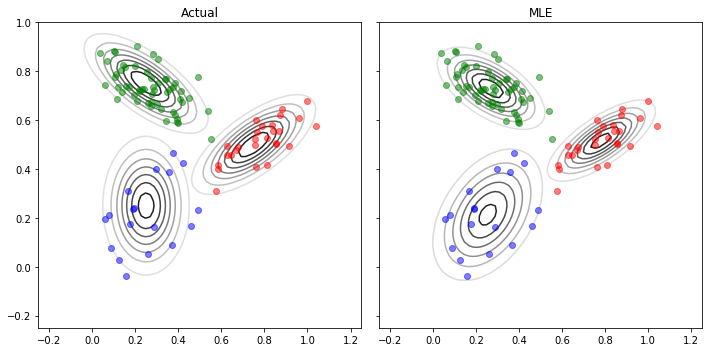

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

from scipy.stats import multivariate_normal

# Graph actual
plot_gaussian_contours(means, covs, ax1, -0.5, 1.5, -0.5, 1.5)
for i, marker in [(0, 'bo'), (1, 'ro'), (2, 'go')]:
    ax1.plot(points[states[:-1]==i, 0], points[states[:-1]==i, 1], marker, alpha=0.5)

# Graph MLE
plot_gaussian_contours(hmm.means, hmm.covs, ax2, -0.5, 1.5, -0.5, 1.5)
for i, marker in [(0, 'bo'), (1, 'ro'), (2, 'go')]:
    ax2.plot(points[states[:-1]==i, 0], points[states[:-1]==i, 1], marker, alpha=0.5)

ax1.set_title('Actual')
ax2.set_title('MLE')
ax2.set_xlim([-0.25, 1.25])
ax2.set_ylim([-0.25, 1])
plt.tight_layout()
plt.show()

What if we fitted with 4 states?

Likelihood 340220823781.97656
Likelihood 4.004424808710439e+55
Likelihood 3.9476197271263913e+61
Likelihood 2.49381192378852e+62
Likelihood 3.5863973986638777e+62
Likelihood 4.291355680159705e+62
Likelihood 4.704752008921955e+62
Likelihood 4.935460243568738e+62
Likelihood 5.067873033879645e+62
Likelihood 5.151854760797259e+62
Likelihood 5.213293078674575e+62
Likelihood 5.264853057899744e+62
Likelihood 5.312574755094695e+62
Likelihood 5.359315885778708e+62
Likelihood 5.406432692253026e+62


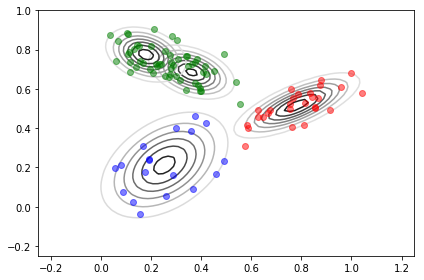

In [6]:
hmm = HMMGaussian(4)
hmm.fit(points)

plot_gaussian_contours(hmm.means, hmm.covs, plt, -0.5, 1.5, -0.5, 1.5)
for i, marker in [(0, 'bo'), (1, 'ro'), (2, 'go'), (3, 'ko')]:
    plt.plot(points[states[:-1]==i, 0], points[states[:-1]==i, 1], marker, alpha=0.5)

plt.xlim([-0.25, 1.25])
plt.ylim([-0.25, 1])
plt.tight_layout()
plt.show()

#### Viterbi algorithm
To actually decode the sequence of points into the latent variables, we have to find the most probable sequence of states through the Viterbi algorithm. This is derived from algorithms on graphical models, and it amounts to the recursion (using log probabilities)
$$\omega\left(\vec{z}_{n+1}\right)=\log p\left(\vec{x}_{n+1}\big|\vec{z}_{n+1}\right) + \max_{\vec{z}_n}\left(\log p\left(\vec{z}_{n+1}|\vec{z}_n\right) + \omega\left(\vec{z}_n\right)\right)$$
with initialization
$$\omega\left(\vec{z}_1\right)=\ln p\left(\vec{z}_1\right) + \ln p\left(\vec{x}_1\big|\vec{z}_1\right).$$

Here is the modified version of the Python object created above with the Viterbi algorithm implemented:

In [7]:
import numpy as np
from scipy.stats import multivariate_normal as gaussian
from sklearn.cluster import KMeans

class HMMGaussian:
    def __init__(self, K):
        self.K = K
        self.A = test = np.random.rand(K, K)
        self.A /= np.sum(self.A, axis=1).reshape(-1, 1)
        
        self.pis = np.random.rand(K, 1)
        self.pis /= sum(self.pis)

        self.N = None # Number of training points
        self.D = None # Dimension of training points
        self.means = None
        self.covs = None
        self.alphas = None
        self.betas = None
        self.xis = None
        self.pX = None
    
    def fit(self, X, verbose=True):
        self.N, self.D = X.shape
        
        # use k means to initialize self.means, self.covs
        kmeans = KMeans(n_clusters=self.K).fit(X)
        self.means = kmeans.cluster_centers_
        self.covs = np.zeros([self.K, self.D, self.D])
        for k in range(self.K):
            self.covs[k] = np.cov(X[kmeans.labels_==k].T)

        # EM
        max_iters = 15
        for _ in range(max_iters):
            self.alphas = np.zeros([self.N, self.K])
            self.betas = np.zeros([self.N, self.K])
            self.forward(X)
            self.backward(X)
            self.pX = np.sum(self.alphas[-1])
            self.xis = np.zeros([self.N-1, self.K, self.K])
            for n in range(self.N-1):
                self.xis[n] = (self.alphas[n].reshape(-1, 1) @ self.betas[n+1].reshape(-1, 1).T) * self.A
                pxz = [gaussian.pdf(X[n+1], mean=self.means[i], cov=self.covs[i]) for i in range(self.K)]
                self.xis[n] *= pxz/self.pX
        
            self.pis = self.alphas[0]/sum(self.alphas[0])
            self.A = np.sum(self.xis, axis=0)
            self.A /= np.sum(self.A, axis=1).reshape(-1, 1)

            self.ml_mean_and_cov(X)
            if verbose: print('Likelihood', self.pX)
        return self.most_probable_sequence(X)
            
    def forward(self, X):
        self.alphas[0] = [self.pis[i] * gaussian.pdf(X[0], mean=self.means[i], cov=self.covs[i])
                          for i in range(self.K)]
        for n in range(1, self.N):
            self.alphas[n] = [gaussian.pdf(X[n], mean=self.means[i], cov=self.covs[i]) *
                              sum(self.alphas[n-1][j] * self.A[j, i] for j in range(self.K))
                              for i in range(self.K)]

    def backward(self, X):
        self.betas[-1] = 1
        for n in range(self.N-2, -1, -1):
            self.betas[n] = [sum(self.betas[n+1][j] * gaussian.pdf(X[n+1], mean=self.means[j], cov=self.covs[j]) * self.A[i, j] for j in range(self.K))
                             for i in range(self.K)]
    
    def ml_mean_and_cov(self, X):
        for k in range(self.K):
            factor = sum(self.alphas[n][k] * self.betas[n][k] for n in range(self.N))
            self.means[k] = sum(self.alphas[n][k] * self.betas[n][k] * X[n] for n in range(self.N))/factor

            cov = 0
            for n in range(self.N):
                c = (points[n] - self.means[k]).reshape(-1, 1) @ (points[n] - self.means[k]).reshape(-1, 1).T
                cov += self.alphas[n][k] * self.betas[n][k] * c
            self.covs[k] = cov/factor
        
    def most_probable_sequence(self, X):
        omegas = np.zeros([self.N, self.K])
        omegas[0] = [np.log(self.pis[i]) + gaussian.pdf(X[0], mean=self.means[i], cov=self.covs[i])
                     for i in range(self.K)]
        for n in range(1, hmm.N):
            omegas[n] = [np.log(gaussian.pdf(X[n], mean=self.means[i], cov=self.covs[i])) 
                         for i in range(self.K)]
            omegas[n] += np.max(np.log(self.A)+ omegas[0].reshape(-1, 1), axis=0)
        return np.argmax(omegas, axis=1)

In [8]:
hmm = HMMGaussian(3)
sequence = hmm.fit(points, verbose=False)

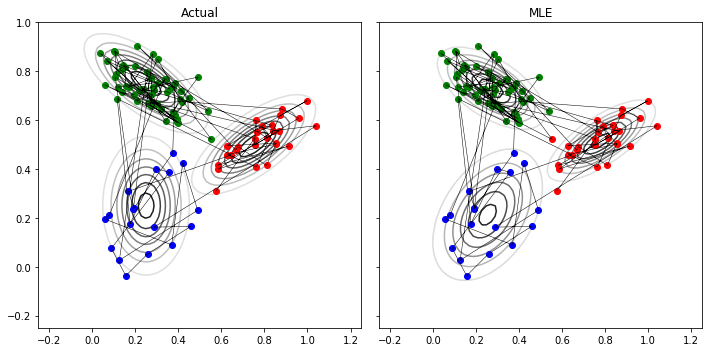

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

from scipy.stats import multivariate_normal

plot_gaussian_contours(means, covs, ax1, -0.5, 1.5, -0.5, 1.5)
for i, marker in [(0, 'bo'), (1, 'ro'), (2, 'go')]:
    ax1.plot(points[states[:-1]==i, 0], points[states[:-1]==i, 1], marker)
ax1.plot(points[:, 0], points[:, 1], 'k-', lw=0.5)
ax1.set_title('Actual')

plot_gaussian_contours(hmm.means, hmm.covs, ax2, -0.5, 1.5, -0.5, 1.5)
for i, marker in [(0, 'go'), (1, 'ro'), (2, 'bo')]:
    ax2.plot(points[sequence==i, 0], points[sequence==i, 1], marker)
ax2.plot(points[:, 0], points[:, 1], 'k-', lw=0.5)
ax2.set_title('MLE')

ax2.set_xlim([-0.25, 1.25])
ax2.set_ylim([-0.25, 1])
plt.tight_layout()
plt.show()

We can see that only one of the estimated latent variables was wrong from the original state. Here are the transition probabilities and other estimated parameters compared to the actual:

In [10]:
print('Actual transition matrix')
print(A)
print('MLE transition matrix')
print(hmm.A)

print('Actual means')
print(means)
print('MLE means')
print(hmm.means)

print('Actual covariances')
print(covs)
print('Estimated covariances')
print(hmm.covs)

Actual transition matrix
[[0.9  0.05 0.05]
 [0.05 0.9  0.05]
 [0.05 0.05 0.9 ]]
MLE transition matrix
[[8.88705867e-01 7.31378977e-02 3.81562355e-02]
 [1.11430418e-01 8.16272362e-01 7.22972196e-02]
 [2.22271895e-01 5.48633988e-34 7.77728105e-01]]
Actual means
[[0.25 0.25]
 [0.75 0.5 ]
 [0.25 0.75]]
MLE means
[[0.26984666 0.73053098]
 [0.78212097 0.51592238]
 [0.25351264 0.21262501]]
Actual covariances
[[[ 0.01  0.  ]
  [ 0.    0.02]]

 [[ 0.02  0.01]
  [ 0.01  0.01]]

 [[ 0.02 -0.01]
  [-0.01  0.01]]]
Estimated covariances
[[[ 0.01523801 -0.0061422 ]
  [-0.0061422   0.00684676]]

 [[ 0.01561929  0.00756254]
  [ 0.00756254  0.00680219]]

 [[ 0.01757327  0.00779426]
  [ 0.00779426  0.0195853 ]]]
